# Leer las ondas
1) Imports

In [34]:
%load_ext oct2py.ipython
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from oct2py import octave
#para el tiempo
from datetime import datetime
import pandas as pd
octave.addpath('/home/scidb/HeartRatePatterns/Matlab/')
octave.eval('pkg load signal')

The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


Leer la base de datos para decidir que Ondas vamos a traer

In [33]:
def obtainWaveFormFields(dbname="mimic") :
    labels='II'
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = "SELECT lef.subject_id,lef.recorddate,lef.signame,lef.fs FROM waveformfields lef  LEFT JOIN (SELECT MAX(recorddate) AS recorddate,subject_id FROM waveformFields GROUP BY subject_id) rig ON lef.subject_id = rig.subject_id AND lef.recorddate = rig.recorddate WHERE rig.subject_id IS NOT NULL AND signame @> ARRAY['"+labels+"']::varchar[]"
    cur.execute(select_stament)
    waves = []
    for row in cur :
        patient = "p"+str(row[0]).zfill(6)
        onda = patient+'-'+row[1]
        carpeta = patient[:3]+"/"+patient
        waves.append({"subject_id":row[0],"recorddate":row[1],"fs":row[3],"onda":onda,"carpeta":carpeta,
                      "signalII":row[2].index("II")})
    conn.close()
    return waves
carpeta = waves[0]["carpeta"]
onda = waves[0]["onda"]
signalII = waves[0]["signalII"]
fs = waves[0]["fs"]
subject_id = waves[0]["subject_id"]
recorddate = waves[0]["recorddate"]

In [3]:
signal = wfdb.rdsamp(onda,pbdir='mimic3wdb/matched/'+carpeta,channels =[signalII]).p_signals
subsignal = signal[-1800000:,0].tolist()
len("La señal tiene ",signal," registros extraemos las ultimas 4 horas")

Extraemos las ultimas 4 horas osea 1'800.000 registros

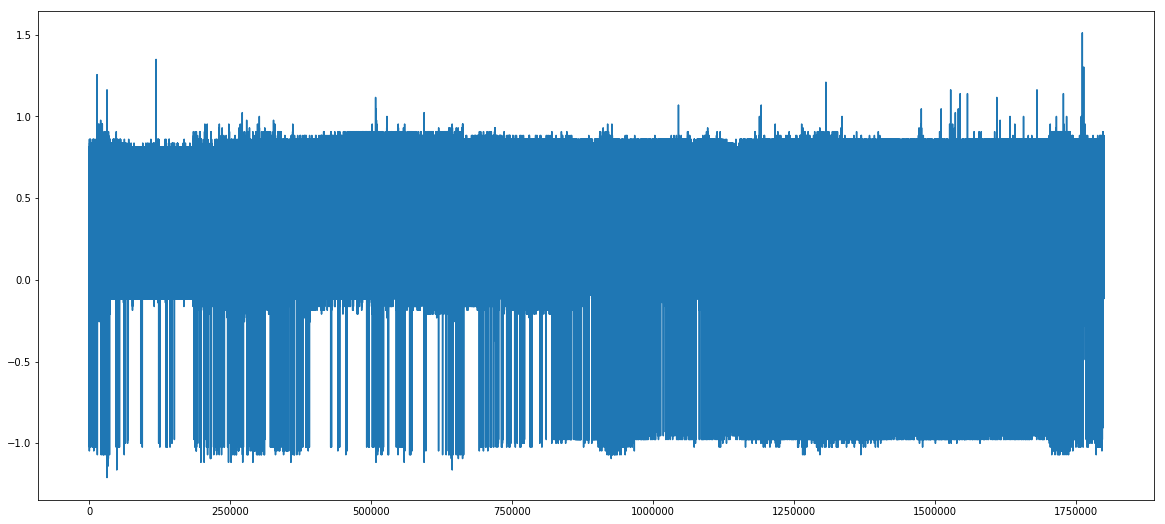

In [6]:
fig_size = [20,9]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(subsignal)
#plt.plot(signal[:,1])
plt.show()

In [8]:
def peakdetect(signal, fs,increment=0,previousResult=None):
    if previousResult is None:
        previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
    %octave [R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot] = peakdetect(signal,fs,false); -i signal,fs -o R_i,R_amp,S_i,S_amp,T_i,T_amp,Q_i,Q_amp,heart_rate,buffer_plot
    return {'Q_i'  :np.concatenate((previousResult['Q_i'],  Q_i[0]+increment)),
            'Q_amp':np.concatenate((previousResult['Q_amp'],Q_amp[0])),
            'R_i'  :np.concatenate((previousResult['R_i'],  R_i[0]+increment)),
            'R_amp':np.concatenate((previousResult['R_amp'],R_amp[0])),
            'S_i'  :np.concatenate((previousResult['S_i'],  S_i[0]+increment)),
            'S_amp':np.concatenate((previousResult['S_amp'],S_amp[0])),
            'T_i'  :np.concatenate((previousResult['T_i'],  T_i[0]+increment)),
            'T_amp':np.concatenate((previousResult['T_amp'],T_amp[0])),
           }

In [35]:
windowsize = 1000*fs
first = peakdetect(subsignal[0:windowsize],fs)
second = peakdetect(subsignal[windowsize:windowsize*2],fs,increment=init,previousResult=first)
print(second)

{'R_i': array([  6.50000000e+01,   1.64000000e+02,   2.64000000e+02, ...,
         1.24835000e+05,   1.24928000e+05,   1.25021000e+05]), 'R_amp': array([ 0.48837209,  0.48837209,  0.46511628, ...,  0.46511628,
        0.46511628,  0.48837209]), 'Q_amp': array([-0.04186047, -0.06511628, -0.10697674, ..., -0.09767442,
       -0.10697674, -0.06511628]), 'Q_i': array([  6.00000000e+01,   1.59000000e+02,   2.59000000e+02, ...,
         1.24830000e+05,   1.24923000e+05,   1.25016000e+05]), 'T_amp': array([ 0.10697674,  0.06511628,  0.0744186 , ...,  0.07906977,
        0.05581395,  0.08372093]), 'T_i': array([  1.05000000e+02,   2.05000000e+02,   3.05000000e+02, ...,
         1.24784000e+05,   1.24875000e+05,   1.24968000e+05]), 'S_i': array([  7.60000000e+01,   1.75000000e+02,   2.75000000e+02, ...,
         1.24844000e+05,   1.24938000e+05,   1.25032000e+05]), 'S_amp': array([-0.07906977, -0.09767442, -0.11627907, ..., -0.10697674,
       -0.09767442, -0.07906977])}


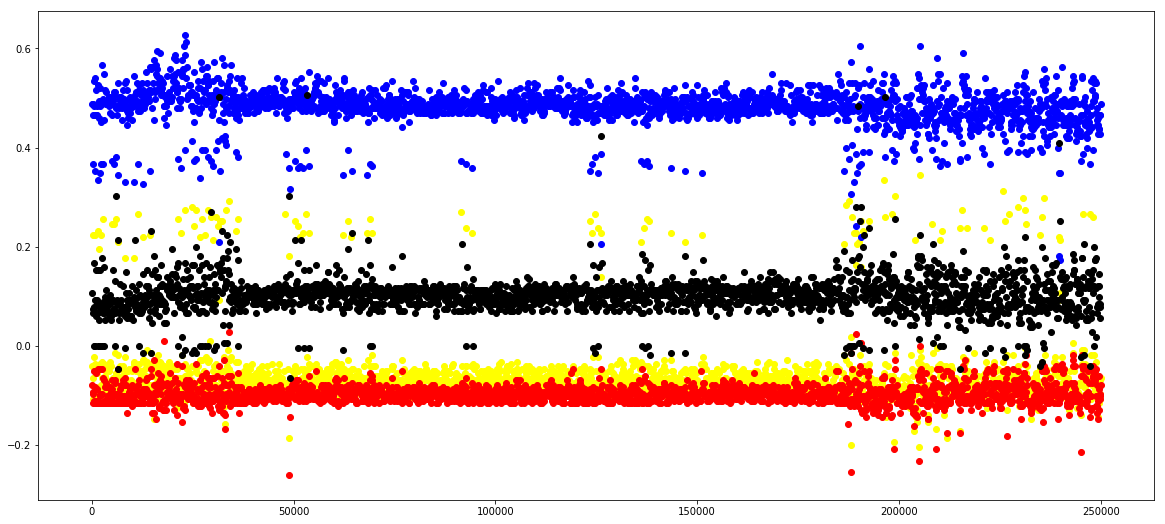

In [11]:
#plt.plot(subsignal[0:end],c='lightgreen')
plt.scatter(second['Q_i'], second['Q_amp'],c='yellow')
plt.scatter(second['R_i'], second['R_amp'],c='blue')
plt.scatter(second['S_i'], second['S_amp'],c='red')
plt.scatter(second['T_i'], second['T_amp'],c='black')
plt.show()

In [36]:
def audit(now = datetime.now()):
    print("hasta aqui van",(now-before))
    return now
def checkwave(signal,fs):
    now = audit()
    windowsize = 1000*fs
    signalsize = len(signal)
    previousResult = {'Q_i':[],'Q_amp':[],'R_i':[],'R_amp':[],'S_i':[],'S_amp':[],'T_i':[],'T_amp':[]}
    termino = True
    fin=0
    while termino:
        ini=fin
        fin=fin+ (windowsize)
        if(fin>signalsize):
            fin=signalsize
        now = audit(now)
        previousResult = peakdetect(signal[ini:fin],fs,increment=ini,previousResult=previousResult)
        now = audit(now)
        termino = fin<signalsize
    return previousResult

In [13]:
previousResult = checkwave(subsignal,fs)
previousResult

inicio 2017-09-24 04:29:31.476186
signal size 1800000 fs 125 windowsize 125000
hasta aqui van 0:00:00.001231


hasta aqui van 0:00:32.139460
Q 1169
R 1169
S 1169
T 1156
peackdetect ini: 0 fin 125000
hasta aqui van 0:00:00.001808


hasta aqui van 0:00:32.427405
Q 2383
R 2383
S 2383
T 2358
peackdetect ini: 125000 fin 250000
hasta aqui van 0:00:00.001560


hasta aqui van 0:00:33.905120
Q 3598
R 3598
S 3598
T 3538
peackdetect ini: 250000 fin 375000
hasta aqui van 0:00:00.002911


hasta aqui van 0:00:35.508491
Q 4713
R 4713
S 4713
T 4644
peackdetect ini: 375000 fin 500000
hasta aqui van 0:00:00.001972


hasta aqui van 0:00:33.922785
Q 5828
R 5828
S 5828
T 5749
peackdetect ini: 500000 fin 625000
hasta aqui van 0:00:00.002083


hasta aqui van 0:00:33.114928
Q 6949
R 6949
S 6949
T 6862
peackdetect ini: 625000 fin 750000
hasta aqui van 0:00:00.001356


hasta aqui van 0:00:32.633477
Q 8062
R 8062
S 8062
T 7968
peackdetect ini: 750000 fin 875000
hasta aqui van 0:00:00.001094


hasta aqui van 0:00:32.221785
Q 9213
R 9213
S 9213
T 9113
peackdetect ini: 875000 fin 1000000
hasta aqui van 0:00:00.001373


hasta aqui van 0:00:31.605643
Q 10365
R 10365
S 10365
T 10260
peackdetect ini: 1000000 fin 1125000
hasta aqui van 0:00:00.002786


hasta aqui van 0:00:34.337734
Q 11506
R 11506
S 11506
T 11395
peackdetect ini: 1125000 fin 1250000
hasta aqui van 0:00:00.001419


hasta aqui van 0:00:33.520249
Q 12620
R 12620
S 12620
T 12504
peackdetect ini: 1250000 fin 1375000
hasta aqui van 0:00:00.001764


hasta aqui van 0:00:33.389939
Q 13730
R 13730
S 13730
T 13611
peackdetect ini: 1375000 fin 1500000
hasta aqui van 0:00:00.001510


hasta aqui van 0:00:39.309934
Q 14833
R 14833
S 14833
T 14712
peackdetect ini: 1500000 fin 1625000
hasta aqui van 0:00:00.001849


hasta aqui van 0:00:35.672179
Q 15942
R 15942
S 15942
T 15820
peackdetect ini: 1625000 fin 1750000
fin 1875000
hasta aqui van 0:00:00.002455


hasta aqui van 0:00:10.750463
Q 16392
R 16392
S 16392
T 16268
peackdetect ini: 1750000 fin 1800000


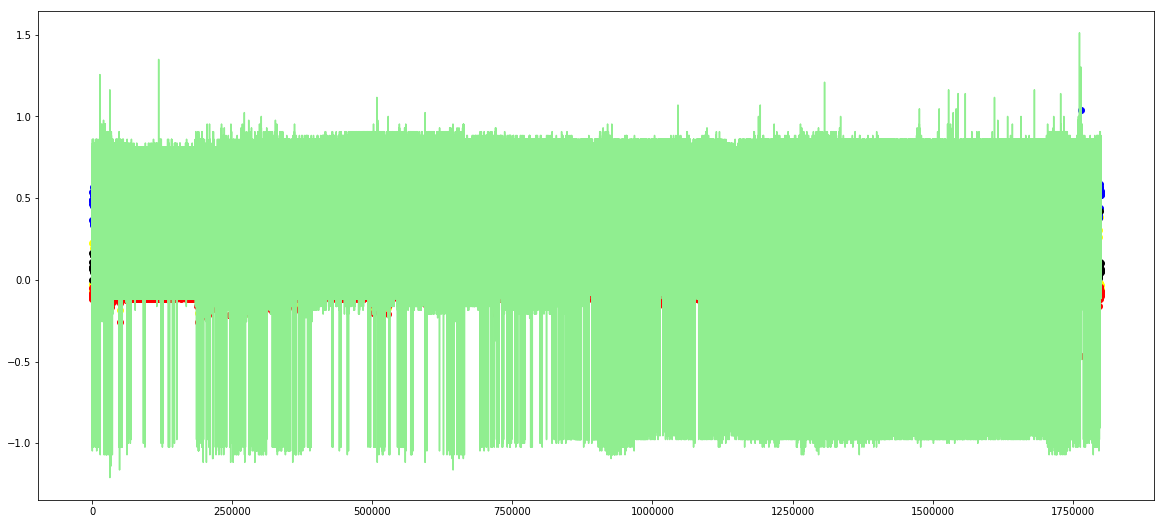

In [15]:
plt.scatter(previousResult['Q_i'], previousResult['Q_amp'],c='yellow')
plt.scatter(previousResult['R_i'], previousResult['R_amp'],c='blue')
plt.scatter(previousResult['S_i'], previousResult['S_amp'],c='red')
plt.scatter(previousResult['T_i'], previousResult['T_amp'],c='black')
plt.plot(subsignal,c='lightgreen')
plt.show()

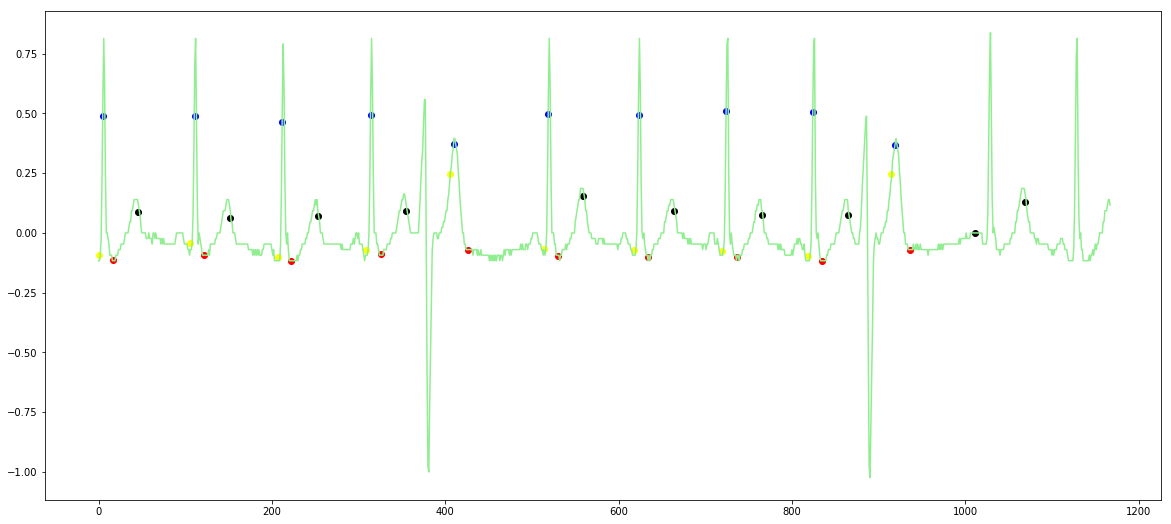

In [16]:
init = 45
end = 55
plt.plot(subsignal[int(previousResult['Q_i'][init]):int(previousResult['T_i'][end])],c='lightgreen')
plt.scatter(previousResult['Q_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['Q_amp'][init:end],c='yellow')
plt.scatter(previousResult['R_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['R_amp'][init:end],c='blue')
plt.scatter(previousResult['S_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['S_amp'][init:end],c='red')
plt.scatter(previousResult['T_i'][init:end]-int(previousResult['Q_i'][init]), previousResult['T_amp'][init:end],c='black')
plt.show()

In [17]:
print('Q',previousResult['Q_i'][504],'R',previousResult['R_i'][504])
print('S',previousResult['S_i'][504],'T',previousResult['T_i'][504])
print('Q',previousResult['Q_i'][505],'R',previousResult['R_i'][505])
print('S',previousResult['S_i'][505],'T',previousResult['T_i'][505])
print(previousResult['T_i'][504]<previousResult['Q_i'][504])

Q 53353.0
R 53358.0
S 53369.0
T 54240.0
Q 53456.0
R 53461.0
S 53472.0
T 54346.0
False


In [18]:
print('Q',len(previousResult['Q_i']), len(previousResult['Q_amp']))
print('R',len(previousResult['R_i']), len(previousResult['R_amp']))
print('S',len(previousResult['S_i']), len(previousResult['S_amp']))
print('T',len(previousResult['T_i']), len(previousResult['T_amp']))

1800000
Q 16392 16392
R 16392 16392
S 16392 16392
T 16268 16268


In [19]:
def sortHeartBeats(signal) :
    iterations = max(len(signal['Q_i']),len(signal['T_i']))
    q,t,result = 0,0,None
    while q<iterations:
        qi,qamp = signal['Q_i'][q],signal['Q_amp'][q]
        ti,tamp = int(signal['T_i'][t]),signal['T_amp'][t]
        if(q+1<iterations) :
            qinext = signal['Q_i'][q+1]
        else :
            qinext = None
        if(qinext is not None and qinext<ti) :
            ti,tamp,t = None,None,t-1
        if ti is not None and ti<qi :
            t=t+1
            ti,tamp = int(signal['T_i'][t]),signal['T_amp'][t]
        if ti is not None and ti<qi :
            print("error en",q,"con t",t)
        dic = {'Q_i':int(qi),'Q_amp':qamp,
              'R_i':int(signal['R_i'][q]),'R_amp':signal['R_amp'][q],
              'S_i':int(signal['S_i'][q]),'S_amp':signal['S_amp'][q],
              'T_i':ti,'T_amp':tamp}
        if result is None :
            result = pd.DataFrame(dic, index=[q])
        else :
            result = pd.concat([result,  pd.DataFrame(dic, index=[q])])
        q,t=q+1,t+1
    print("q",q,"t",t)
    return result
sortBeats = sortHeartBeats(previousResult)
print(sortBeats)

q 16392 t 16268
          Q_amp      Q_i     R_amp      R_i     S_amp      S_i     T_amp  \
0     -0.041860       60  0.488372       65 -0.079070       76  0.106977   
1     -0.065116      159  0.488372      164 -0.097674      175  0.065116   
2     -0.106977      259  0.465116      264 -0.116279      275  0.074419   
3      0.223256      354  0.367442      359 -0.093023      376  0.000000   
4     -0.023256      468  0.534884      473 -0.051163      483  0.167442   
5     -0.097674      570  0.483721      575 -0.111628      587  0.079070   
6     -0.088372      670  0.465116      675 -0.116279      685  0.093023   
7      0.223256      763  0.353488      768 -0.083721      786  0.000000   
8     -0.037209      876  0.539535      881 -0.055814      893  0.153488   
9     -0.088372      979  0.516279      984 -0.111628      995  0.065116   
10    -0.088372     1079  0.465116     1084 -0.116279     1094  0.060465   
11    -0.106977     1179  0.483721     1184 -0.116279     1195  0.093023

In [37]:
def checkQRST(qrst) :
    shape = qrst.shape[0]
    x = 0
    while x<shape :
        if(qrst.iloc[x]["S_i"]-qrst.iloc[x]["Q_i"]<0) :
            print(qrst.iloc[x]["S_i"]-qrst.iloc[x]["Q_i"])
        x=x+1
checkQRST(sortBeats)

In [27]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(np.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(np.int64, addapt_numpy_int64)

In [61]:
sortBeats = sortBeats.assign(subject_id=int(subject_id)).assign(recorddate=recorddate)
sortBeats['QRTSOrder'] = sortBeats.index
def saveQRST(qrst) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    table = "waveformQRST"
    cur.execute("CREATE TABLE IF NOT EXISTS "+table+
            " (id serial PRIMARY KEY,"+
            "Q_amp real,"+
            "Q_i integer,"+
            "R_amp real,"+
            "R_i integer,"+
            "S_amp real,"+
            "S_i integer,"+
            "T_amp real,"+
            "T_i integer,"+
            "subject_id integer,recorddate character varying(255),QRTSOrder integer,"+
            'CONSTRAINT "uniqueQRST" UNIQUE (subject_id, recorddate, qrtsorder));')
    insert_statement = 'insert into '+table+' (%s) values %s'
    for index, row in qrst.iterrows():
        columns = row.keys()
        values = [row[column] for column in columns]
        print(cur.mogrify(insert_statement, (AsIs(','.join(columns)), tuple(values))))
        cur.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))
    conn.commit()
    conn.close()
saveQRST(sortBeats)

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.041860465116279076, 60, 0.4883720930232559, 65,  -0.07906976744186048, 76, 0.1069767441860465, 105, 20, '2183-04-28-17-47', 0)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 159, 0.4883720930232558, 164,  -0.09767441860465116, 175, 0.06511627906976744, 205, 20, '2183-04-28-17-47', 1)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.1069767441860465, 259, 0.4651162790697675, 264,  -0.11627906976744187, 275, 0.07441860465116278, 305, 20, '2183-04-28-17-47', 2)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.22325581395348837, 354, 0.3674418604651163, 359,  -0.09302325581395349, 376, 0.0, 451, 20, '2183-04-28-17-47', 3)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186046, 26919, 0.4790697674418604, 26924,  -0.09302325581395349, 26935, 0.10697674418604652, 26965, 20, '2183-04-28-17-47', 255)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186046, 27022, 0.49302325581395345, 27027,  -0.11162790697674418, 27039, 0.0697674418604651, 27068, 20, '2183-04-28-17-47', 256)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.1069767441860465, 27124, 0.5720930232558139, 27129,  -0.12093023255813953, 27140, 0.0697674418604651, 27170, 20, '2183-04-28-17-47', 257)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.2558139534883721, 27221, 0.3953488372093023, 27226,  -0.08372093023255814, 27243, 0.0, 27322, 20, '2183-04-28-17-47', 258)"
b"ins

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488375, 53251, 0.49302325581395356, 53256,  -0.08372093023255814, 53266, 0.5069767441860465, 53255, 20, '2183-04-28-17-47', 503)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 53353, 0.4837209302325582, 53358,  -0.09302325581395349, 53369, 0.11162790697674418, 53398, 20, '2183-04-28-17-47', 504)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 53456, 0.48372093023255813, 53461,  -0.09302325581395349, 53472, 0.10697674418604652, 53502, 20, '2183-04-28-17-47', 505)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04651162790697675, 53560, 0.48372093023255813, 53565,  -0.09767441860465116, 53576, 0.09767441860465116, 53605, 20, '2183-0

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 83054, 0.4744186046511628, 83059,  -0.10697674418604652, 83071, 0.09767441860465116, 83100, 20, '2183-04-28-17-47', 781)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.055813953488372106, 83164, 0.4744186046511628, 83169,  -0.10232558139534884, 83180, 0.10232558139534884, 83210, 20, '2183-04-28-17-47', 782)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.08837209302325581, 83273, 0.4837209302325582, 83278,  -0.09767441860465116, 83289, 0.11162790697674418, 83319, 20, '2183-04-28-17-47', 783)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.0697674418604651, 83382, 0.4883720930232558, 83387,  -0.10697674418604652, 83399, 0.08372093023255814, 83428, 20, '2183-04-2

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06976744186046512, 123025, 0.4651162790697675, 123030,  -0.11627906976744187, 123042, 0.1069767441860465, 123071, 20, '2183-04-28-17-47', 1150)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.09767441860465116, 123129, 0.5023255813953489, 123134,  -0.11162790697674418, 123146, 0.1069767441860465, 123175, 20, '2183-04-28-17-47', 1151)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186046, 123233, 0.46976744186046504, 123238,  -0.10232558139534884, 123249, 0.11162790697674418, 123279, 20, '2183-04-28-17-47', 1152)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.25116279069767444, 123330, 0.35348837209302325, 123335,  -0.09302325581395349, 123351, 'NaN'::float, NULL, 20, '2

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186048, 162111, 0.49767441860465117, 162116,  -0.09767441860465116, 162127, 0.10232558139534884, 162158, 20, '2183-04-28-17-47', 1513)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.08372093023255814, 162220, 0.49302325581395345, 162225,  -0.09767441860465116, 162237, 0.09302325581395349, 162267, 20, '2183-04-28-17-47', 1514)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.055813953488372106, 162329, 0.49767441860465117, 162334,  -0.09302325581395349, 162345, 0.0697674418604651, 162376, 20, '2183-04-28-17-47', 1515)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.08372093023255814, 162437, 0.4790697674418604, 162442,  -0.10232558139534884, 162453, 0.09302325581395349, 

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06976744186046512, 198712, 0.5069767441860465, 198717,  -0.10232558139534884, 198727, 0.0930232558139535, 198757, 20, '2183-04-28-17-47', 1859)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.19534883720930235, 198813, 0.37209302325581395, 198818,  -0.20930232558139536, 198828, 0.04651162790697675, 198858, 20, '2183-04-28-17-47', 1860)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.3023255813953488, 198914, 0.427906976744186, 198919,  -0.046511627906976744, 198934, 0.0, 198995, 20, '2183-04-28-17-47', 1861)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.013953488372093027, 199016, 0.5348837209302325, 199021,  -0.027906976744186046, 199030, 0.25581395348837205, 199060, 20, '2183-04

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.1069767441860465, 232176, 0.4744186046511628, 232181,  -0.11627906976744187, 232192, 0.0697674418604651, 232221, 20, '2183-04-28-17-47', 2201)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.09767441860465116, 232271, 0.4232558139534883, 232276,  -0.11627906976744187, 232285, 0.07441860465116278, 232316, 20, '2183-04-28-17-47', 2202)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.11627906976744187, 232364, 0.49302325581395345, 232369,  -0.12093023255813953, 232379, 0.037209302325581395, 232409, 20, '2183-04-28-17-47', 2203)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.08837209302325581, 232457, 0.4604651162790699, 232462,  -0.11627906976744187, 232472, 0.07441860465116278, 232

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 266885, 0.41395348837209306, 266890,  -0.1441860465116279, 266904, 0.08837209302325581, 266929, 20, '2183-04-28-17-47', 2552)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.09767441860465116, 266987, 0.43720930232558136, 266992,  -0.11627906976744187, 267005, 0.12558139534883722, 267031, 20, '2183-04-28-17-47', 2553)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.08837209302325581, 267090, 0.4511627906976744, 267095,  -0.09302325581395349, 267106, 0.11627906976744184, 267135, 20, '2183-04-28-17-47', 2554)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 267198, 0.5209302325581395, 267203,  -0.06976744186046512, 267215,  -0.009302325581395349,

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.30697674418604654, 301733, 0.4418604651162791, 301738,  -0.0697674418604651, 301752, 0.0, 301819, 20, '2183-04-28-17-47', 2893)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.06046511627906977, 301840, 0.6558139534883721, 301845, 0.037209302325581395, 301855, 0.20930232558139536, 301886, 20, '2183-04-28-17-47', 2894)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 301944, 0.5674418604651162, 301949,  -0.08372093023255814, 301962, 0.05581395348837209, 301990, 20, '2183-04-28-17-47', 2895)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.11162790697674418, 302052, 0.5069767441860465, 302057,  -0.11627906976744187, 302066, 0.0697674418604651, 302098, 20, '2183-04-28-17

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488372, 328738, 0.5581395348837208, 328743,  -0.046511627906976744, 328754, 0.17209302325581394, 328784, 20, '2183-04-28-17-47', 3159)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 328845, 0.49767441860465117, 328850,  -0.10232558139534884, 328861, 0.06511627906976744, 328891, 20, '2183-04-28-17-47', 3160)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837208, 328948, 0.5069767441860465, 328953,  -0.11627906976744187, 328964, 0.07441860465116278, 328994, 20, '2183-04-28-17-47', 3161)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 329050, 0.49767441860465117, 329055,  -0.09302325581395349, 329066, 0.07441860465116278,

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 362875, 0.5023255813953489, 362880,  -0.09302325581395349, 362891, 0.08372093023255814, 362921, 20, '2183-04-28-17-47', 3484)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.1069767441860465, 362978, 0.4883720930232559, 362983,  -0.10232558139534884, 362996, 0.0697674418604651, 363025, 20, '2183-04-28-17-47', 3485)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.2325581395348837, 363074, 0.3674418604651163, 363079,  -0.11627906976744187, 363096, 0.0, 363178, 20, '2183-04-28-17-47', 3486)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 363188, 0.5674418604651164, 363193,  -0.10232558139534884, 363205, 0.11162790697674418, 363235, 20, '2183-04-28

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.21860465116279068, 388714, 0.3441860465116279, 388719,  -0.11627906976744187, 388736, 'NaN'::float, NULL, 20, '2183-04-28-17-47', 3723)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 388832, 0.5162790697674419, 388837,  -0.09767441860465116, 388849, 0.17674418604651163, 388875, 20, '2183-04-28-17-47', 3724)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.09767441860465116, 388940, 0.4883720930232559, 388945,  -0.11162790697674418, 388957, 0.0697674418604651, 388987, 20, '2183-04-28-17-47', 3725)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186048, 389048, 0.5255813953488373, 389053,  -0.09302325581395349, 389065, 0.08372093023255814, 389095, 20, '21

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 421107, 0.5302325581395348, 421112,  -0.06976744186046512, 421124, 0.11162790697674418, 421153, 20, '2183-04-28-17-47', 4009)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 421220, 0.5255813953488372, 421225,  -0.08372093023255814, 421237, 0.0930232558139535, 421267, 20, '2183-04-28-17-47', 4010)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 421332, 0.5348837209302325, 421337,  -0.07906976744186048, 421349, 0.09767441860465116, 421379, 20, '2183-04-28-17-47', 4011)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 421446, 0.5209302325581395, 421451,  -0.06976744186046512, 421462, 0.1069767441860465, 4214

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.08372093023255814, 453335, 0.530232558139535, 453340,  -0.10232558139534884, 453351, 0.07906976744186046, 453382, 20, '2183-04-28-17-47', 4297)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06976744186046512, 453449, 0.5627906976744186, 453454,  -0.08837209302325581, 453466, 0.08372093023255814, 453496, 20, '2183-04-28-17-47', 4298)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.027906976744186053, 453562, 0.5488372093023256, 453567,  -0.046511627906976744, 453578, 0.14883720930232558, 453607, 20, '2183-04-28-17-47', 4299)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 453675, 0.5348837209302324, 453680,  -0.06511627906976744, 453693, 0.11162790697674418, 45

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 491512, 0.5255813953488372, 491517,  -0.08837209302325581, 491528, 0.0697674418604651, 491559, 20, '2183-04-28-17-47', 4636)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04651162790697676, 491622, 0.5023255813953489, 491627,  -0.08372093023255814, 491638, 0.0697674418604651, 491669, 20, '2183-04-28-17-47', 4637)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04651162790697675, 491733, 0.5209302325581395, 491738,  -0.09767441860465116, 491749, 0.08372093023255814, 491779, 20, '2183-04-28-17-47', 4638)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 491842, 0.5534883720930232, 491847,  -0.0744186046511628, 491860, 0.09767441860465116, 491889

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.09302325581395349, 528009, 0.4604651162790698, 528014,  -0.15813953488372096, 528027, 'NaN'::float, NULL, 20, '2183-04-28-17-47', 4967)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.17209302325581394, 528118, 0.4418604651162791, 528123,  -0.20930232558139536, 528134, 0.0, 528161, 20, '2183-04-28-17-47', 4968)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.13488372093023257, 528229, 0.49767441860465117, 528234,  -0.07906976744186048, 528244, 0.213953488372093, 528276, 20, '2183-04-28-17-47', 4969)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.027906976744186046, 528340, 0.6558139534883722, 528345, 0.0, 528355, 0.1395348837209302, 528386, 20, '2183-04-28-17-47', 4970)"
b"insert i

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03720930232558141, 560319, 0.530232558139535, 560324,  -0.08372093023255814, 560335, 0.08372093023255814, 560365, 20, '2183-04-28-17-47', 5259)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 560429, 0.5534883720930233, 560434,  -0.07441860465116279, 560445, 0.11162790697674418, 560475, 20, '2183-04-28-17-47', 5260)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.060465116279069774, 560539, 0.5348837209302325, 560544,  -0.09302325581395349, 560556, 0.07441860465116279, 560586, 20, '2183-04-28-17-47', 5261)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 560649, 0.5348837209302325, 560654,  -0.06511627906976744, 560666, 0.11162790697674418, 560

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 587633, 0.5441860465116279, 587638,  -0.06976744186046512, 587650, 0.11162790697674418, 587680, 20, '2183-04-28-17-47', 5500)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 587750, 0.5953488372093023, 587755,  -0.06511627906976744, 587767, 0.09767441860465116, 587797, 20, '2183-04-28-17-47', 5501)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 587868, 0.5767441860465117, 587873,  -0.06511627906976744, 587884, 0.11162790697674418, 587915, 20, '2183-04-28-17-47', 5502)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.02325581395348837, 587985, 0.5348837209302325, 587990,  -0.07906976744186048, 588002, 0.11162790697674418, 5

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 613290, 0.5209302325581395, 613295,  -0.06976744186046512, 613307, 0.08837209302325581, 613337, 20, '2183-04-28-17-47', 5725)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 613404, 0.5395348837209302, 613409,  -0.06976744186046512, 613421, 0.11162790697674418, 613450, 20, '2183-04-28-17-47', 5726)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.027906976744186053, 613519, 0.5488372093023256, 613524,  -0.055813953488372106, 613536, 0.11162790697674418, 613565, 20, '2183-04-28-17-47', 5727)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 613635, 0.5209302325581395, 613640,  -0.06511627906976744, 613652, 0.0883720930232558, 61

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 641777, 0.5162790697674419, 641782,  -0.07906976744186048, 641793, 0.0930232558139535, 641822, 20, '2183-04-28-17-47', 5980)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 641881, 0.5116279069767442, 641886,  -0.06976744186046512, 641897, 0.07906976744186046, 641927, 20, '2183-04-28-17-47', 5981)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04651162790697676, 641986, 0.5023255813953489, 641991,  -0.08372093023255814, 642002, 0.05581395348837209, 642032, 20, '2183-04-28-17-47', 5982)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.23720930232558138, 642079, 0.35348837209302325, 642084,  -0.12093023255813953, 642100,  -0.018604651162790697, 64

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06976744186046513, 675970, 0.5023255813953489, 675975,  -0.06976744186046512, 675987, 0.09302325581395349, 676017, 20, '2183-04-28-17-47', 6287)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 676083, 0.5302325581395347, 676088,  -0.0744186046511628, 676101, 0.08372093023255814, 676130, 20, '2183-04-28-17-47', 6288)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 676196, 0.5255813953488372, 676201,  -0.0744186046511628, 676213, 0.07906976744186046, 676243, 20, '2183-04-28-17-47', 6289)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04651162790697675, 676310, 0.5023255813953489, 676315,  -0.07441860465116279, 676326, 0.0930232558139535, 676356

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.060465116279069774, 703206, 0.5674418604651164, 703211,  -0.08837209302325581, 703223, 0.0697674418604651, 703253, 20, '2183-04-28-17-47', 6528)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.227906976744186, 703300, 0.32558139534883723, 703305,  -0.11627906976744187, 703321,  -0.023255813953488372, 703393, 20, '2183-04-28-17-47', 6529)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.004651162790697674, 703428, 0.5488372093023256, 703433,  -0.05116279069767442, 703444, 0.11162790697674418, 703475, 20, '2183-04-28-17-47', 6530)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488375, 703539, 0.5302325581395348, 703544,  -0.05581395348837209, 703555, 0.08372093023255814, 7

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 734568, 0.5209302325581395, 734573,  -0.06976744186046512, 734585, 0.08372093023255814, 734612, 20, '2183-04-28-17-47', 6810)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.027906976744186046, 734679, 0.5162790697674419, 734684,  -0.06046511627906977, 734696, 0.07441860465116278, 734724, 20, '2183-04-28-17-47', 6811)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 734792, 0.530232558139535, 734797,  -0.046511627906976744, 734808, 0.0930232558139535, 734837, 20, '2183-04-28-17-47', 6812)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 734905, 0.5209302325581395, 734910,  -0.06046511627906977, 734922, 0.06511627906976744, 73

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 760610, 0.5395348837209303, 760615,  -0.06511627906976744, 760627, 0.0930232558139535, 760656, 20, '2183-04-28-17-47', 7043)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 760724, 0.5581395348837209, 760729,  -0.08837209302325581, 760741, 0.0930232558139535, 760770, 20, '2183-04-28-17-47', 7044)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 760838, 0.5488372093023256, 760843,  -0.07906976744186048, 760856, 0.08837209302325581, 760884, 20, '2183-04-28-17-47', 7045)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.041860465116279076, 760953, 0.4883720930232559, 760958,  -0.08372093023255814, 760968, 0.08372093023255814, 760

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 808359, 0.5534883720930233, 808364,  -0.055813953488372106, 808377, 0.10232558139534884, 808405, 20, '2183-04-28-17-47', 7467)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 808475, 0.5581395348837209, 808480,  -0.06976744186046512, 808492, 0.10232558139534884, 808521, 20, '2183-04-28-17-47', 7468)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.018604651162790697, 808592, 0.5069767441860465, 808597,  -0.06046511627906977, 808608, 0.0697674418604651, 808639, 20, '2183-04-28-17-47', 7469)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 808707, 0.5162790697674419, 808712,  -0.07906976744186048, 808725, 0.08837209302325581, 8

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 847705, 0.5209302325581395, 847710,  -0.06976744186046512, 847722, 0.08837209302325581, 847751, 20, '2183-04-28-17-47', 7817)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 847816, 0.5255813953488373, 847821,  -0.06976744186046513, 847834, 0.07906976744186046, 847862, 20, '2183-04-28-17-47', 7818)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 847926, 0.5023255813953489, 847931,  -0.09302325581395349, 847942, 0.06511627906976744, 847972, 20, '2183-04-28-17-47', 7819)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 848037, 0.5162790697674419, 848042,  -0.0744186046511628, 848054, 0.08372093023255814, 8480

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.19534883720930232, 880620, 0.32093023255813957, 880625,  -0.1069767441860465, 880642, 0.009302325581395349, 880685, 20, '2183-04-28-17-47', 8113)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 880756, 0.5069767441860465, 880761,  -0.08372093023255814, 880772, 0.06976744186046512, 880800, 20, '2183-04-28-17-47', 8114)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04651162790697675, 880868, 0.5069767441860465, 880873,  -0.06046511627906977, 880885, 0.06046511627906977, 880912, 20, '2183-04-28-17-47', 8115)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.17209302325581396, 880955, 0.30697674418604654, 880960,  -0.1069767441860465, 880977, 0.009302325581395349, 8810

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.02790697674418604, 910298, 0.49767441860465117, 910303,  -0.06511627906976744, 910313, 0.10697674418604652, 910340, 20, '2183-04-28-17-47', 8385)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04651162790697675, 910404, 0.5116279069767442, 910409,  -0.08372093023255814, 910421, 0.05116279069767442, 910448, 20, '2183-04-28-17-47', 8386)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.22790697674418606, 910492, 0.3767441860465116, 910497,  -0.12093023255813953, 910512, 0.013953488372093023, 910556, 20, '2183-04-28-17-47', 8387)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186046, 910617, 0.5023255813953489, 910622,  -0.08837209302325581, 910635, 0.07906976744186046, 910

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 946933, 0.4883720930232559, 946938,  -0.07906976744186048, 946950, 0.06046511627906977, 946978, 20, '2183-04-28-17-47', 8724)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.22325581395348837, 947021, 0.35348837209302325, 947026,  -0.12093023255813953, 947040, 0.027906976744186046, 947085, 20, '2183-04-28-17-47', 8725)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 947142, 0.5302325581395348, 947147,  -0.09767441860465116, 947158, 0.07441860465116279, 947186, 20, '2183-04-28-17-47', 8726)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 947247, 0.4837209302325582, 947252,  -0.07441860465116279, 947262, 0.06511627906976744, 947

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.24186046511627907, 982418, 0.35348837209302325, 982423,  -0.13023255813953488, 982439,  -0.027906976744186046, 982503, 20, '2183-04-28-17-47', 9054)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488375, 982540, 0.5441860465116279, 982545,  -0.046511627906976744, 982556, 0.11162790697674418, 982585, 20, '2183-04-28-17-47', 9055)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 982650, 0.5348837209302325, 982655,  -0.055813953488372106, 982666, 0.12093023255813955, 982694, 20, '2183-04-28-17-47', 9056)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 982759, 0.5255813953488373, 982764,  -0.06976744186046512, 982776, 0.06511627906976744

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.26046511627906976, 1013777, 0.3441860465116279, 1013782,  -0.12558139534883722, 1013796, 0.04186046511627907, 1013851, 20, '2183-04-28-17-47', 9339)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 1013905, 0.4930232558139534, 1013910,  -0.09302325581395349, 1013921, 0.06511627906976744, 1013950, 20, '2183-04-28-17-47', 9340)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1014011, 0.5209302325581395, 1014016,  -0.06511627906976744, 1014027, 0.06976744186046512, 1014056, 20, '2183-04-28-17-47', 9341)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1014117, 0.5488372093023256, 1014122,  -0.0744186046511628, 1014134, 0.0697674418

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.2558139534883721, 1045496, 0.530232558139535, 1045501,  -0.11627906976744187, 1045516, 0.023255813953488372, 1045562, 20, '2183-04-28-17-47', 9631)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1045629, 0.5302325581395348, 1045634,  -0.0744186046511628, 1045645, 0.06976744186046512, 1045675, 20, '2183-04-28-17-47', 9632)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1045741, 0.5348837209302325, 1045746,  -0.07906976744186048, 1045758, 0.07441860465116278, 1045786, 20, '2183-04-28-17-47', 9633)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 1045853, 0.5255813953488372, 1045858,  -0.06976744186046512, 1045868, 0.0651162790

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.041860465116279076, 1078903, 0.49302325581395356, 1078908,  -0.08837209302325581, 1078919, 0.08837209302325581, 1078947, 20, '2183-04-28-17-47', 9940)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1079010, 0.4883720930232558, 1079015,  -0.09302325581395349, 1079026, 0.05581395348837209, 1079055, 20, '2183-04-28-17-47', 9941)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.08837209302325581, 1079116, 0.4651162790697675, 1079121,  -0.11627906976744187, 1079131, 0.04186046511627907, 1079160, 20, '2183-04-28-17-47', 9942)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 1079224, 0.5162790697674419, 1079229,  -0.05116279069767442, 1079240, 0.10697

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 1110351, 0.5255813953488373, 1110356,  -0.08372093023255814, 1110368, 0.09767441860465116, 1110395, 20, '2183-04-28-17-47', 10229)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1110462, 0.5116279069767442, 1110467,  -0.06046511627906977, 1110478, 0.07441860465116279, 1110507, 20, '2183-04-28-17-47', 10230)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.21395348837209305, 1110552, 0.35348837209302325, 1110557,  -0.11627906976744187, 1110572, 0.023255813953488372, 1110619, 20, '2183-04-28-17-47', 10231)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 1110680, 0.5209302325581395, 1110685,  -0.08372093023255814, 1110697, 0.0744

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1145089, 0.4837209302325582, 1145094,  -0.0744186046511628, 1145104, 0.07441860465116278, 1145133, 20, '2183-04-28-17-47', 10548)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186048, 1145194, 0.49302325581395356, 1145199,  -0.10232558139534884, 1145210, 0.08837209302325581, 1145238, 20, '2183-04-28-17-47', 10549)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 1145306, 0.4883720930232559, 1145311,  -0.0697674418604651, 1145321, 0.08837209302325581, 1145350, 20, '2183-04-28-17-47', 10550)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 1145414, 0.49302325581395356, 1145419,  -0.08372093023255814, 1145430, 0.065

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 1179913, 0.49302325581395345, 1179918,  -0.08837209302325581, 1179931, 0.04651162790697675, 1179958, 20, '2183-04-28-17-47', 10868)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 1180021, 0.5162790697674418, 1180026,  -0.06976744186046512, 1180038, 0.06976744186046512, 1180065, 20, '2183-04-28-17-47', 10869)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06976744186046512, 1180131, 0.5348837209302325, 1180136,  -0.07906976744186048, 1180148, 0.07441860465116279, 1180175, 20, '2183-04-28-17-47', 10870)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1180239, 0.49302325581395345, 1180244,  -0.05116279069767442, 1180252, 0.1

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 1214301, 0.5023255813953489, 1214306,  -0.08837209302325581, 1214316, 0.07906976744186046, 1214345, 20, '2183-04-28-17-47', 11182)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1214406, 0.5488372093023256, 1214411,  -0.07906976744186048, 1214423, 0.06046511627906977, 1214450, 20, '2183-04-28-17-47', 11183)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.09767441860465116, 1214509, 0.4837209302325582, 1214514,  -0.11162790697674418, 1214526, 0.04186046511627907, 1214553, 20, '2183-04-28-17-47', 11184)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.11162790697674418, 1214612, 0.4883720930232559, 1214617,  -0.10697674418604652, 1214629, 0.0837

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 1251085, 0.5116279069767442, 1251090,  -0.10232558139534884, 1251102, 0.06046511627906977, 1251129, 20, '2183-04-28-17-47', 11515)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 1251196, 0.5395348837209303, 1251201,  -0.06511627906976744, 1251213, 0.06046511627906977, 1251241, 20, '2183-04-28-17-47', 11516)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.013953488372093023, 1251306, 0.5302325581395348, 1251311,  -0.06046511627906977, 1251322, 0.07906976744186046, 1251350, 20, '2183-04-28-17-47', 11517)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 1251419, 0.5441860465116279, 1251424,  -0.06976744186046512, 1251436, 0.06

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 1288549, 0.5255813953488371, 1288554,  -0.08837209302325581, 1288566, 0.06976744186046512, 1288593, 20, '2183-04-28-17-47', 11851)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 1288661, 0.5209302325581395, 1288666,  -0.06511627906976744, 1288676, 0.07441860465116278, 1288705, 20, '2183-04-28-17-47', 11852)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 1288773, 0.5209302325581395, 1288778,  -0.06976744186046513, 1288790, 0.11162790697674418, 1288816, 20, '2183-04-28-17-47', 11853)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.2837209302325582, 1288873, 0.3767441860465116, 1288878,  -0.12093023255813953, 1288893,  -0.02790

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.19069767441860463, 1326859, 0.36279069767441857, 1326864,  -0.13023255813953488, 1326879, 0.013953488372093023, 1326926, 20, '2183-04-28-17-47', 12194)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488375, 1326990, 0.5209302325581395, 1326995,  -0.055813953488372106, 1327006, 0.0930232558139535, 1327034, 20, '2183-04-28-17-47', 12195)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 1327099, 0.5023255813953489, 1327104,  -0.1069767441860465, 1327116, 0.05116279069767442, 1327143, 20, '2183-04-28-17-47', 12196)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 1327210, 0.5674418604651162, 1327215,  -0.046511627906976744, 1327226, 0.10

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.055813953488372106, 1364491, 0.5162790697674418, 1364496,  -0.10232558139534884, 1364508, 0.04186046511627907, 1364535, 20, '2183-04-28-17-47', 12526)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.018604651162790697, 1364605, 0.5255813953488372, 1364610,  -0.06511627906976744, 1364621, 0.07441860465116278, 1364648, 20, '2183-04-28-17-47', 12527)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 1364716, 0.5441860465116279, 1364721,  -0.06976744186046512, 1364733, 0.06046511627906977, 1364760, 20, '2183-04-28-17-47', 12528)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488375, 1364832, 0.5209302325581395, 1364837,  -0.06976744186046512, 1364848, 0.0

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 1402648, 0.5395348837209302, 1402653,  -0.06511627906976744, 1402665, 0.06511627906976744, 1402692, 20, '2183-04-28-17-47', 12866)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07906976744186048, 1402761, 0.5488372093023256, 1402766,  -0.09302325581395349, 1402778, 0.08837209302325581, 1402805, 20, '2183-04-28-17-47', 12867)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.2744186046511628, 1402854, 0.3813953488372093, 1402859,  -0.09302325581395349, 1402874, 0.03255813953488372, 1402919, 20, '2183-04-28-17-47', 12868)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06976744186046513, 1402984, 0.5255813953488373, 1402989,  -0.09302325581395349, 1403001, 0.0651162

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.25116279069767444, 1440619, 0.386046511627907, 1440624,  -0.11627906976744187, 1440638, 0.0, 1440684, 20, '2183-04-28-17-47', 13203)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 1440751, 0.5069767441860465, 1440756,  -0.06511627906976744, 1440768, 0.06976744186046512, 1440795, 20, '2183-04-28-17-47', 13204)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.027906976744186053, 1440863, 0.5162790697674419, 1440868,  -0.06976744186046512, 1440880, 0.08372093023255814, 1440905, 20, '2183-04-28-17-47', 13205)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06046511627906977, 1440978, 0.5209302325581395, 1440983,  -0.0744186046511628, 1440995, 0.06511627906976744, 1441

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.07441860465116279, 1478109, 0.4930232558139534, 1478114,  -0.11162790697674418, 1478126, 0.04186046511627907, 1478153, 20, '2183-04-28-17-47', 13538)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.055813953488372106, 1478219, 0.5116279069767442, 1478224,  -0.07906976744186048, 1478236, 0.05116279069767442, 1478263, 20, '2183-04-28-17-47', 13539)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 1478330, 0.5069767441860465, 1478335,  -0.07906976744186048, 1478349, 0.06046511627906977, 1478374, 20, '2183-04-28-17-47', 13540)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.060465116279069774, 1478441, 0.4976744186046512, 1478446,  -0.06976744186046512, 1478458, 0.05

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06976744186046512, 1515725, 0.5441860465116279, 1515730,  -0.08837209302325581, 1515742, 0.04651162790697675, 1515769, 20, '2183-04-28-17-47', 13867)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 1515836, 0.5116279069767441, 1515841,  -0.055813953488372106, 1515853, 0.05581395348837209, 1515880, 20, '2183-04-28-17-47', 13868)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 1515947, 0.5488372093023256, 1515952,  -0.04186046511627907, 1515961, 0.08837209302325581, 1515990, 20, '2183-04-28-17-47', 13869)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.22325581395348837, 1516036, 0.35348837209302325, 1516041,  -0.11627906976744187, 1516055, 0.0,

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.18139534883720929, 1554285, 0.33023255813953484, 1554290,  -0.11627906976744187, 1554305, 0.0, 1554351, 20, '2183-04-28-17-47', 14207)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05116279069767442, 1554425, 0.5162790697674419, 1554430,  -0.06976744186046512, 1554442, 0.06046511627906977, 1554469, 20, '2183-04-28-17-47', 14208)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 1554539, 0.5348837209302325, 1554544,  -0.05581395348837209, 1554556, 0.0930232558139535, 1554581, 20, '2183-04-28-17-47', 14209)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.2558139534883721, 1554631, 0.4, 1554636,  -0.11627906976744187, 1554651, 0.0, 1554696, 20, '2183-04-28-17-47', 142

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.037209302325581395, 1593347, 0.5395348837209302, 1593352,  -0.06511627906976744, 1593364, 0.07906976744186046, 1593390, 20, '2183-04-28-17-47', 14553)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.24651162790697678, 1593443, 0.33488372093023255, 1593444,  -0.11162790697674418, 1593452, 0.009302325581395349, 1593501, 20, '2183-04-28-17-47', 14554)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1593582, 0.5534883720930233, 1593587,  -0.07906976744186048, 1593599, 0.05581395348837209, 1593626, 20, '2183-04-28-17-47', 14555)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.018604651162790697, 1593699, 0.5209302325581395, 1593704,  -0.06511627906976744, 1593716, 0.04

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1632455, 0.5116279069767442, 1632460,  -0.06976744186046512, 1632471, 0.05581395348837209, 1632499, 20, '2183-04-28-17-47', 14898)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.05581395348837209, 1632568, 0.5488372093023256, 1632573,  -0.06976744186046512, 1632585, 0.06511627906976744, 1632612, 20, '2183-04-28-17-47', 14899)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.24186046511627907, 1632659, 0.3627906976744186, 1632664,  -0.11627906976744187, 1632679, 0.004651162790697674, 1632723, 20, '2183-04-28-17-47', 14900)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.027906976744186046, 1632794, 0.5023255813953489, 1632799,  -0.0744186046511628, 1632811, 0.06511

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.22325581395348837, 1669300, 0.3488372093023256, 1669305,  -0.11627906976744187, 1669317, 0.0, 1669365, 20, '2183-04-28-17-47', 15221)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1669440, 0.5395348837209302, 1669445,  -0.06511627906976744, 1669458, 0.05116279069767442, 1669485, 20, '2183-04-28-17-47', 15222)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488375, 1669557, 0.5116279069767442, 1669562,  -0.06046511627906977, 1669572, 0.05116279069767442, 1669600, 20, '2183-04-28-17-47', 15223)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.22325581395348837, 1669648, 0.37209302325581395, 1669653,  -0.11627906976744187, 1669667, 0.0, 1669713, 20, '2183-

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.027906976744186046, 1707094, 0.5348837209302326, 1707099,  -0.07441860465116279, 1707111, 0.06511627906976744, 1707137, 20, '2183-04-28-17-47', 15558)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1707195, 0.5627906976744186, 1707200,  -0.06046511627906977, 1707211, 0.06976744186046512, 1707239, 20, '2183-04-28-17-47', 15559)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.023255813953488372, 1707301, 0.5255813953488372, 1707306,  -0.05116279069767442, 1707315, 0.07441860465116278, 1707344, 20, '2183-04-28-17-47', 15560)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.027906976744186046, 1707407, 0.5348837209302325, 1707412,  -0.0744186046511628, 1707424, 0.06

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.2558139534883721, 1744906, 0.386046511627907, 1744911,  -0.12558139534883722, 1744926, 0.0, 1745009, 20, '2183-04-28-17-47', 15896)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1745023, 0.5488372093023255, 1745028,  -0.06046511627906977, 1745039, 0.0930232558139535, 1745068, 20, '2183-04-28-17-47', 15897)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.046511627906976744, 1745135, 0.5302325581395348, 1745140,  -0.06976744186046512, 1745152, 0.07906976744186046, 1745179, 20, '2183-04-28-17-47', 15898)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.21860465116279074, 1745223, 0.37209302325581395, 1745228,  -0.11627906976744187, 1745242, 0.004651162790697674, 17452

b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.06511627906976744, 1782260, 0.5116279069767442, 1782265,  -0.08837209302325581, 1782276, 0.07441860465116278, 1782304, 20, '2183-04-28-17-47', 16233)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values (0.29767441860465116, 1782360, 0.4046511627906977, 1782365,  -0.12093023255813953, 1782379, 0.009302325581395349, 1782427, 20, '2183-04-28-17-47', 16234)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.04186046511627907, 1782486, 0.5209302325581395, 1782491,  -0.07906976744186048, 1782503, 0.06976744186046512, 1782530, 20, '2183-04-28-17-47', 16235)"
b"insert into waveformQRST (Q_amp,Q_i,R_amp,R_i,S_amp,S_i,T_amp,T_i,subject_id,recorddate,QRTSOrder) values ( -0.03255813953488372, 1782599, 0.5116279069767441, 1782604,  -0.06046511627906977, 1782614, 0.06511